## CS441: Applied ML - HW 2

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [253]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression

!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
import faiss
import time

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

### Part 1: PCA and Data Compression

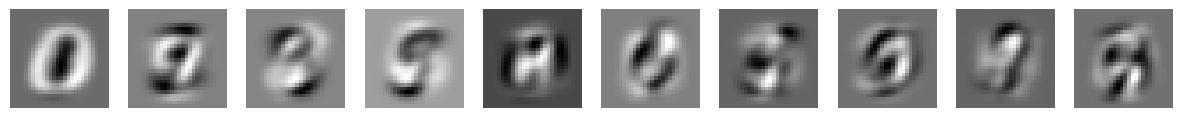

In [254]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Compute the first 10 principal components using x_train
pca_model = PCA()
pca_model.fit(x_train)
principal_components = pca_model.components_[:10]

# Display First 10 Components
display_mnist(principal_components, 1, 10)



<Axes: >

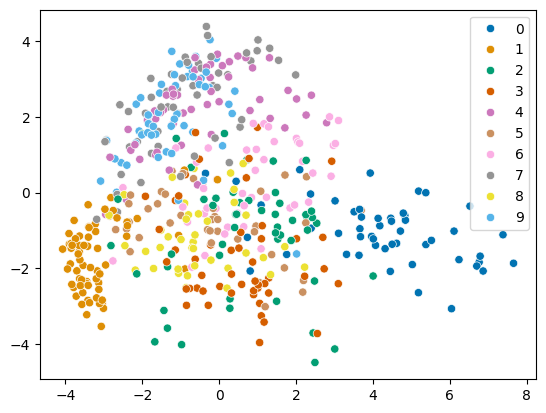

In [57]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

# use pca.transform
x = pca_model.transform(x_train[:500])
# TO DO
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind")

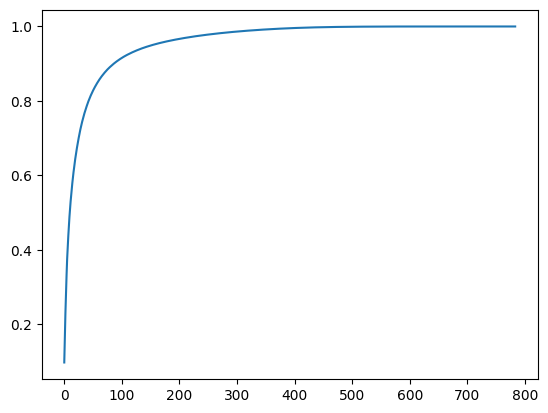

In [58]:
# Plot cumulative explained variance ratio
# cumsum and pca.explained_variance_ratio_ will be useful

# TO DO
cum_var = np.cumsum(pca_model.explained_variance_ratio_)
plt.plot(cum_var)

In [59]:
# Select number of dimensions that explains 90% of variance, according to your plot above
m = (cum_var >= 0.9).argmax() + 1
print(m)

pca_model = PCA(n_components=m).fit(x_train)

# Get time and error when using original features with brute force 1-NN
# TO DO
start = time.time()
index = faiss.IndexFlatL2(x_train.shape[1])
index.add(x_train)
dist, idx = index.search(x_test,1)
pred = y_train[idx.squeeze()]
err = (pred != y_test).mean()
print(err)
print(time.time() - start)

# Get time and error when using compressed features with brute force 1-NN
# TO DO
x_train_comp = pca_model.transform(x_train)
x_test_comp = pca_model.transform(x_test)

start = time.time()
index = faiss.IndexFlatL2(x_train_comp.shape[1])
index.add(x_train_comp)
dist, idx = index.search(x_test_comp,1)
pred = y_train[idx.squeeze()]
err = (pred != y_test).mean()
print(err)
print(time.time() - start)




87
0.0309
36.031790018081665
0.0273
4.545729160308838


### Part 2: MNIST Classification with Linear Models

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

LLR/SVM vs training size

In [14]:
# LLR
for n in [100, 1000, 10000, 60000]:
  LLR = LogisticRegression(max_iter = 10000).fit(x_train[:n],y_train[:n])
  pred = LLR.predict(x_test)
  err = 100*(pred != y_test).mean()
  print(err)

32.5
13.639999999999999
9.5
7.380000000000001


In [7]:
# SVM
for n in [100, 1000, 10000, 60000]:
  SVM = LinearSVC(max_iter = 10000).fit(x_train[:n],y_train[:n])
  pred = SVM.predict(x_test)
  err = 100*(pred != y_test).mean()
  print(err)

/home/matty/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/matty/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


32.35
16.11


/home/matty/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


11.12


/home/matty/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


8.17


Error visualization

idx 0
0.9999999963899942 0.00025819211990930365
idx 1
0.9996567977883941 3.0877626333995e-07
idx 2
0.9999999744316168 8.143784266293726e-08
idx 3
0.9999989329684581 2.559199561611065e-05
idx 4
0.9999997898596669 1.332051810719343e-07
idx 5
0.9999795469879909 0.00011521805519352722
idx 6
0.9999992170012151 9.196212267621756e-05
idx 7
0.9999978520581978 2.8968218320809687e-06
idx 8
0.9999939555425639 2.7513009347682197e-05
idx 9
0.9999710313820391 1.0870533123166027e-07


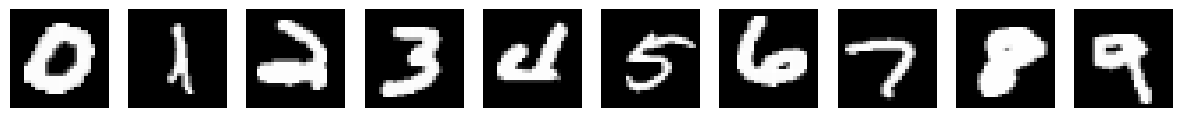

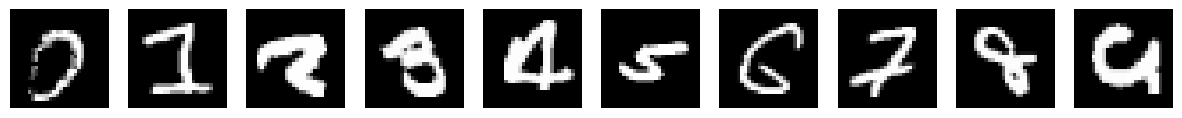

idx 0
4.61895263661966 -2.6070372181055292
idx 1
2.4273329555515355 -5.02282639157594
idx 2
4.3457220804306536 -4.503737615673133
idx 3
4.294225965182193 -4.2211613082993695
idx 4
3.769328884272958 -4.4923061471241255
idx 5
4.0326785525818565 -4.385248350034097
idx 6
3.9589625796426087 -3.189884761323814
idx 7
5.565132589995729 -4.641314083206345
idx 8
2.6371411849356683 -2.8530038389350647
idx 9
3.0858680559435063 -4.077201020006369


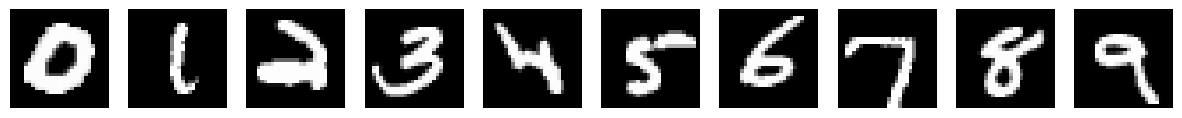

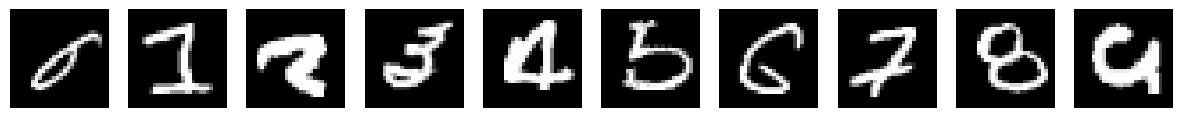

In [54]:
# to get scores for logistic regression use: scores = model_lr.predict_proba(x_test)
def makeplots(scores):
  mostcorrect = np.empty((10, x_test.shape[1]))
  mostwrong = mostcorrect.copy()
  for i in range(10):
    print(f"idx {i}")
    probs = scores[:,i]
    islabel = (y_test == i).astype(int)
  
    maxidx = (probs * islabel).argmax()
    minidx = ((1-probs) * islabel).argmax()
    print(probs[maxidx], probs[minidx])
    # display_mnist(x_test[minidx])
    # display_mnist(x_test[maxidx])
    mostcorrect[i] = x_test[maxidx]
    mostwrong[i] = x_test[minidx]

  display_mnist(mostcorrect,subplot_cols=10)
  display_mnist(mostwrong,subplot_cols=10)

makeplots(LLR.predict_proba(x_test))
# to get scores for SVM use: scores = model_svm.decision_function(x_test)
makeplots(SVM.decision_function(x_test))

Parameter selection

In [255]:
cs = []
errs = []

In [264]:
# Try multiple C parameters, select one that minimizes validation error
# Often, you need to try a few values and see those results to determine what other values to try


def geterr(c):
  model = LinearSVC(C=c, dual='auto').fit(x_train[:1000], y_train[:1000])
  pred = model.predict(x_train[50000:])
  err = (pred != y_train[50000:]).mean()
  print(c, err)
  cs.append(c)
  errs.append(err)
  return err

minval = 1000
minc = -1

for c in np.linspace(0.0185,0.0199,10):
  err = geterr(c)
  if err < minval:
    minval = err
    minc = c
    
print(minc, minval)

0.0185 0.1239
0.018655555555555554 0.1238
0.018811111111111112 0.1237
0.018966666666666666 0.1236
0.01912222222222222 0.1237
0.01927777777777778 0.1238
0.019433333333333334 0.1237
0.01958888888888889 0.1235
0.019744444444444446 0.1237
0.0199 0.1238
0.01958888888888889 0.1235


0.1235
0.1358


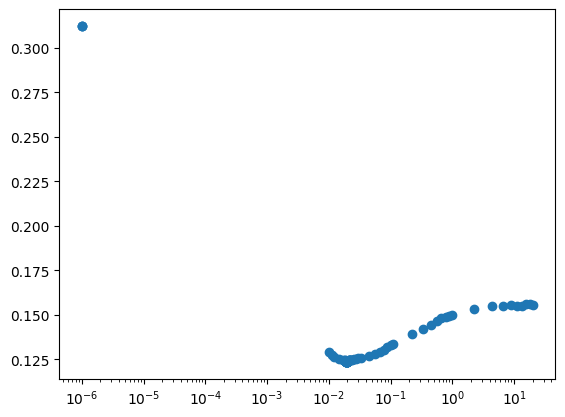

In [265]:
# Get test result for selected parameter
plt.semilogx(cs,errs, marker='o', linestyle='')
# TO DO
c = cs[np.argmin(errs)]
print(min(errs))
model = LinearSVC(C=c, dual='auto').fit(x_train[:1000], y_train[:1000])
pred = model.predict(x_test)
err = (pred != y_test).mean()
print(err)

## Part 3: Temperature Regression


In [125]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  # drive.mount('/content/drive')
  # datadir = "/content/drive/My Drive/CS441/24SP/hw1/"
  datadir = './'
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


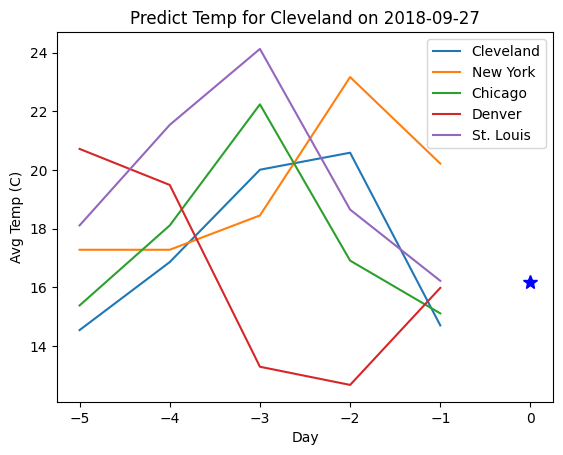

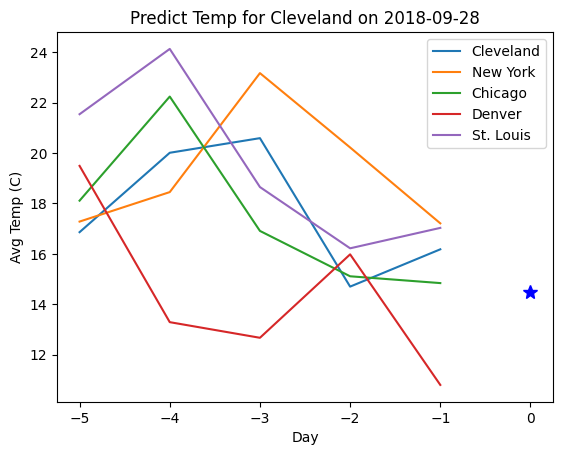

In [126]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



Linear regression test

In [127]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

In [135]:
# linear regression (use Ridge)

# original features
model = Ridge().fit(x_train,y_train)
pred = model.predict(x_test)
print(np.sqrt(np.square(pred-y_test).mean()))

# normalized features
fnum=361
xnorm_train,ynorm_train = normalize_features(x_train,y_train,fnum)
xnorm_test, ynorm_test = normalize_features(x_test,y_test,fnum)


y_pred = Ridge().fit(xnorm_train,ynorm_train).predict(xnorm_test)

print(np.square(y_pred - ynorm_test).mean()**0.5)
# TO DO

2.1608605260795755
2.1630698027575606


Feature selection

In [169]:
# feature analysis (select important features using Lasso)
# TO DO
model = Lasso().fit(x_train,y_train)
fidx = (np.abs(model.coef_)>0.001)
fidx = np.arange(x_train.shape[1])[fidx]

import pandas as pd
df = pd.DataFrame({
'coef': np.abs(model.coef_[fidx]),
    'fnum':fidx,
'city':feature_to_city[fidx],
  'day':feature_to_day[fidx],

})
df = df.sort_values('coef',ascending=False)
df

,coef,fnum,city,day
6,0.279599,334,Chicago,-1
7,0.225942,347,Minneapolis,-1
12,0.180130,405,Grand Rapids,-1
10,0.162950,366,Kansas City,-1
9,0.138357,361,Cleveland,-1
5,0.111248,307,Omaha,-2
11,0.046103,367,Indianapolis,-1
3,0.043280,264,Minneapolis,-2
0,0.025518,9,Boston,-5
2,0.025198,236,Springfield,-3


In [267]:
# predict using best features
idxs = df['fnum'][:10].values
model = Ridge().fit(x_train[:,idxs],y_train)
pred = model.predict(x_test[:,idxs])
print(np.sqrt(np.square(pred-y_test).mean()))

2.7350935573443653


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

# 4a

In [190]:

from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc,roc_auc_score,PrecisionRecallDisplay
import sklearn.metrics as metrics


(x_train, y_train), (x_test, y_test) = load_mnist()
y_train = y_train == 0
y_test = y_test == 0
model = LogisticRegression().fit(x_train,y_train)

Average Precision (AP): 0.9888354276370754
Area under the ROC curve (AuROC): 0.9983122539481425


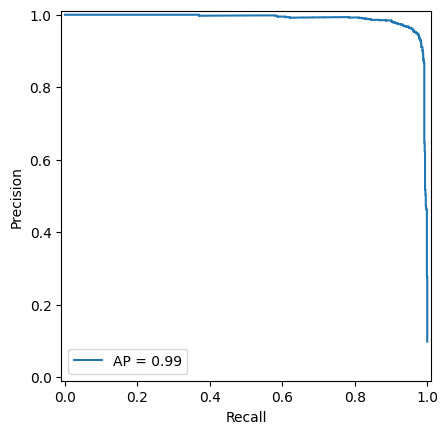

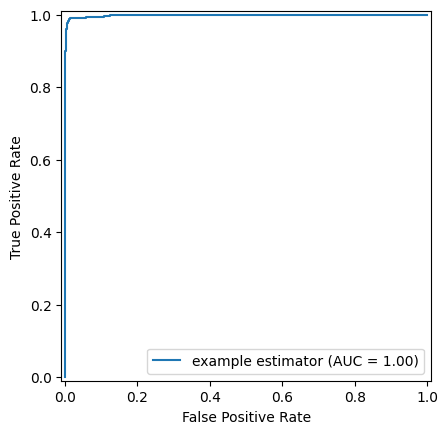

In [192]:
probs = model.predict_proba(x_test)[:,1]

average_precision = average_precision_score(y_test, probs)
print('Average Precision (AP):', average_precision)

auroc = roc_auc_score(y_test,probs)
print('Area under the ROC curve (AuROC):', auroc)

precision, recall, _ = precision_recall_curve(y_test, probs)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
disp.plot()


precision, recall, _ = precision_recall_curve(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
auroc = roc_auc_score(y_test,probs)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auroc,estimator_name='example estimator')
display.plot()
fpr, tpr, _ = roc_curve(y_test, probs)





# 4b

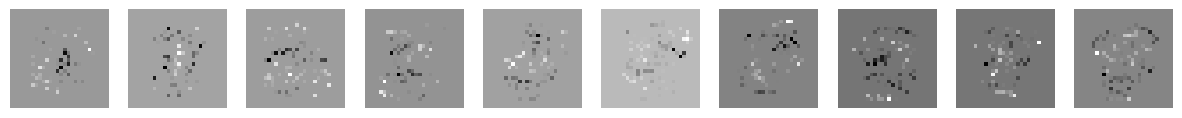

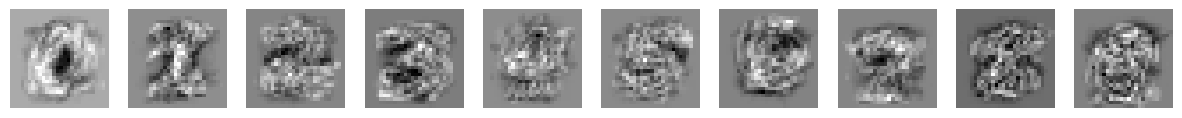

/home/matty/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


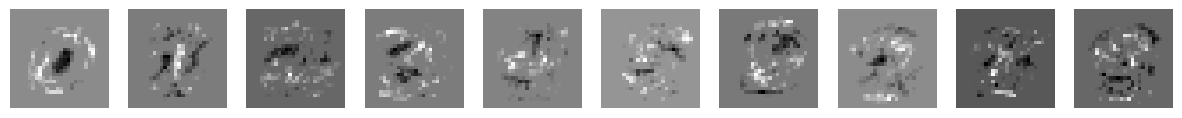

/home/matty/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


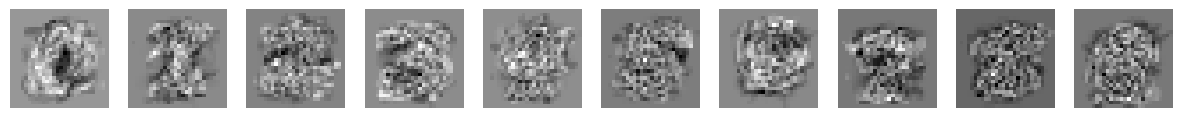

In [212]:
(x_train, y_train), (x_test, y_test) = load_mnist()


def go(model):
  model.fit(x_train[:1000],y_train[:1000])
  display_mnist(model.coef_, subplot_cols=10)
  

go(LogisticRegression(penalty='l1',solver='liblinear'))
go(LogisticRegression(penalty='l2',solver='liblinear'))
go(LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5))
go(LinearSVC())

# 4c

<Axes: >

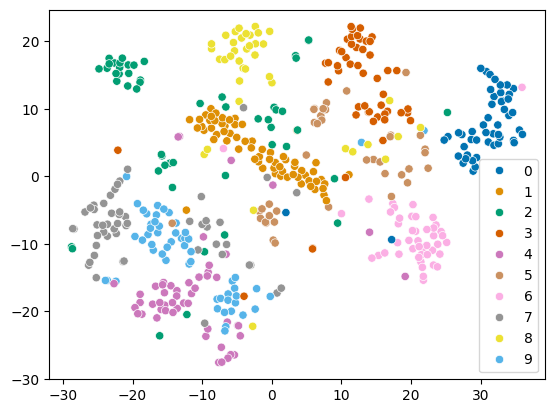

In [218]:

from sklearn.manifold import TSNE
from sklearn.manifold import MDS
(x_train, y_train), (x_test, y_test) = load_mnist()

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(x_train[:500])

# MDS
mds = MDS(n_components=2)
X_mds = mds.fit_transform(x_train[:500])

# Plotting

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train[:500], palette="colorblind")


<Axes: >

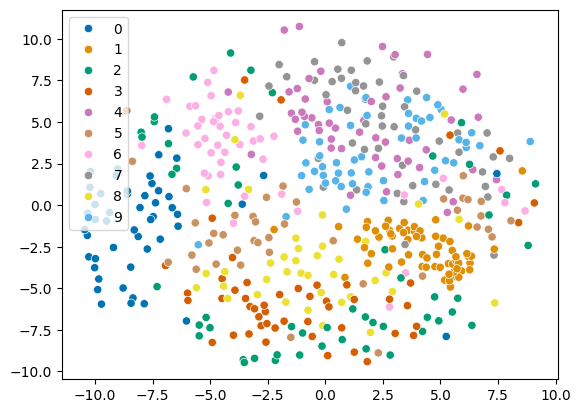

In [217]:
sns.scatterplot(x=X_mds[:, 0], y=X_mds[:, 1], hue=y_train[:500], palette="colorblind")

# 4D

In [246]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

def RMSE(a,b):
  return np.sqrt(np.square(a-b).mean())

errs  = []
for i in range(83):
  x = x_train[:, i:415:83]
  xv = x_val[:,i:415:83]
  model = Ridge().fit(x, y_train)
  pred = model.predict(xv)
  err = RMSE(pred, y_val)
  errs.append(err)

imin = np.argmin(errs)
print(imin, feature_to_city[imin])
x = x_train[:, imin:415:83]
model = Ridge().fit(x, y_train)
pred = model.predict(x_test[:,imin:415:83])
err = RMSE(pred, y_test)
print(err)
  

22 St. Louis
3.1263272970544764


# 4e

In [220]:

from sklearn.svm import SVC
# SVM
for n in [100, 1000, 10000, 60000]:
  SVM = SVC(max_iter = 10000).fit(x_train[:n],y_train[:n])
  pred = SVM.predict(x_test)
  err = 100*(pred != y_test).mean()
  print(err)

34.410000000000004
9.17
4.06
2.08


In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/
PDF CREATED: /content/drive/My Drive/CS441/24SP/hw1/CS441_SP24_HW1_Solution.pdf
